# Import common package

In [4]:
import torch
from torch import nn, optim

from jcopdl.callback import Callback, set_config

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
import random

In [5]:
print(torch.__version__)

1.12.1


In [6]:
device = torch.device("cpu")

# Exploration Data

In [7]:
kelas = []
n_gmbar = []
data = {'JenisTanaman':[], 'JumlahFoto':[]}

for i in os.listdir('DATASET TANAMAN HERBAL/Data Training'):
    n_gmbar.append(len(os.listdir('DATASET TANAMAN HERBAL/Data Training/'+i)))
    kelas.append(i)
    
data['JenisTanaman']+=kelas
data['JumlahFoto']+=n_gmbar

df = pd.DataFrame(data)
df

,JenisTanaman,JumlahFoto
0,Daun Jambu Biji,80
1,Daun Kari,80
2,Daun Kemangi,80
3,Daun Kunyit,80
4,Daun Mint,80
5,Daun Pepaya,80
6,Daun Sirih,80
7,Daun Sirsak,80
8,Lidah Buaya,80
9,Teh Hijau,80


# Data Visualization

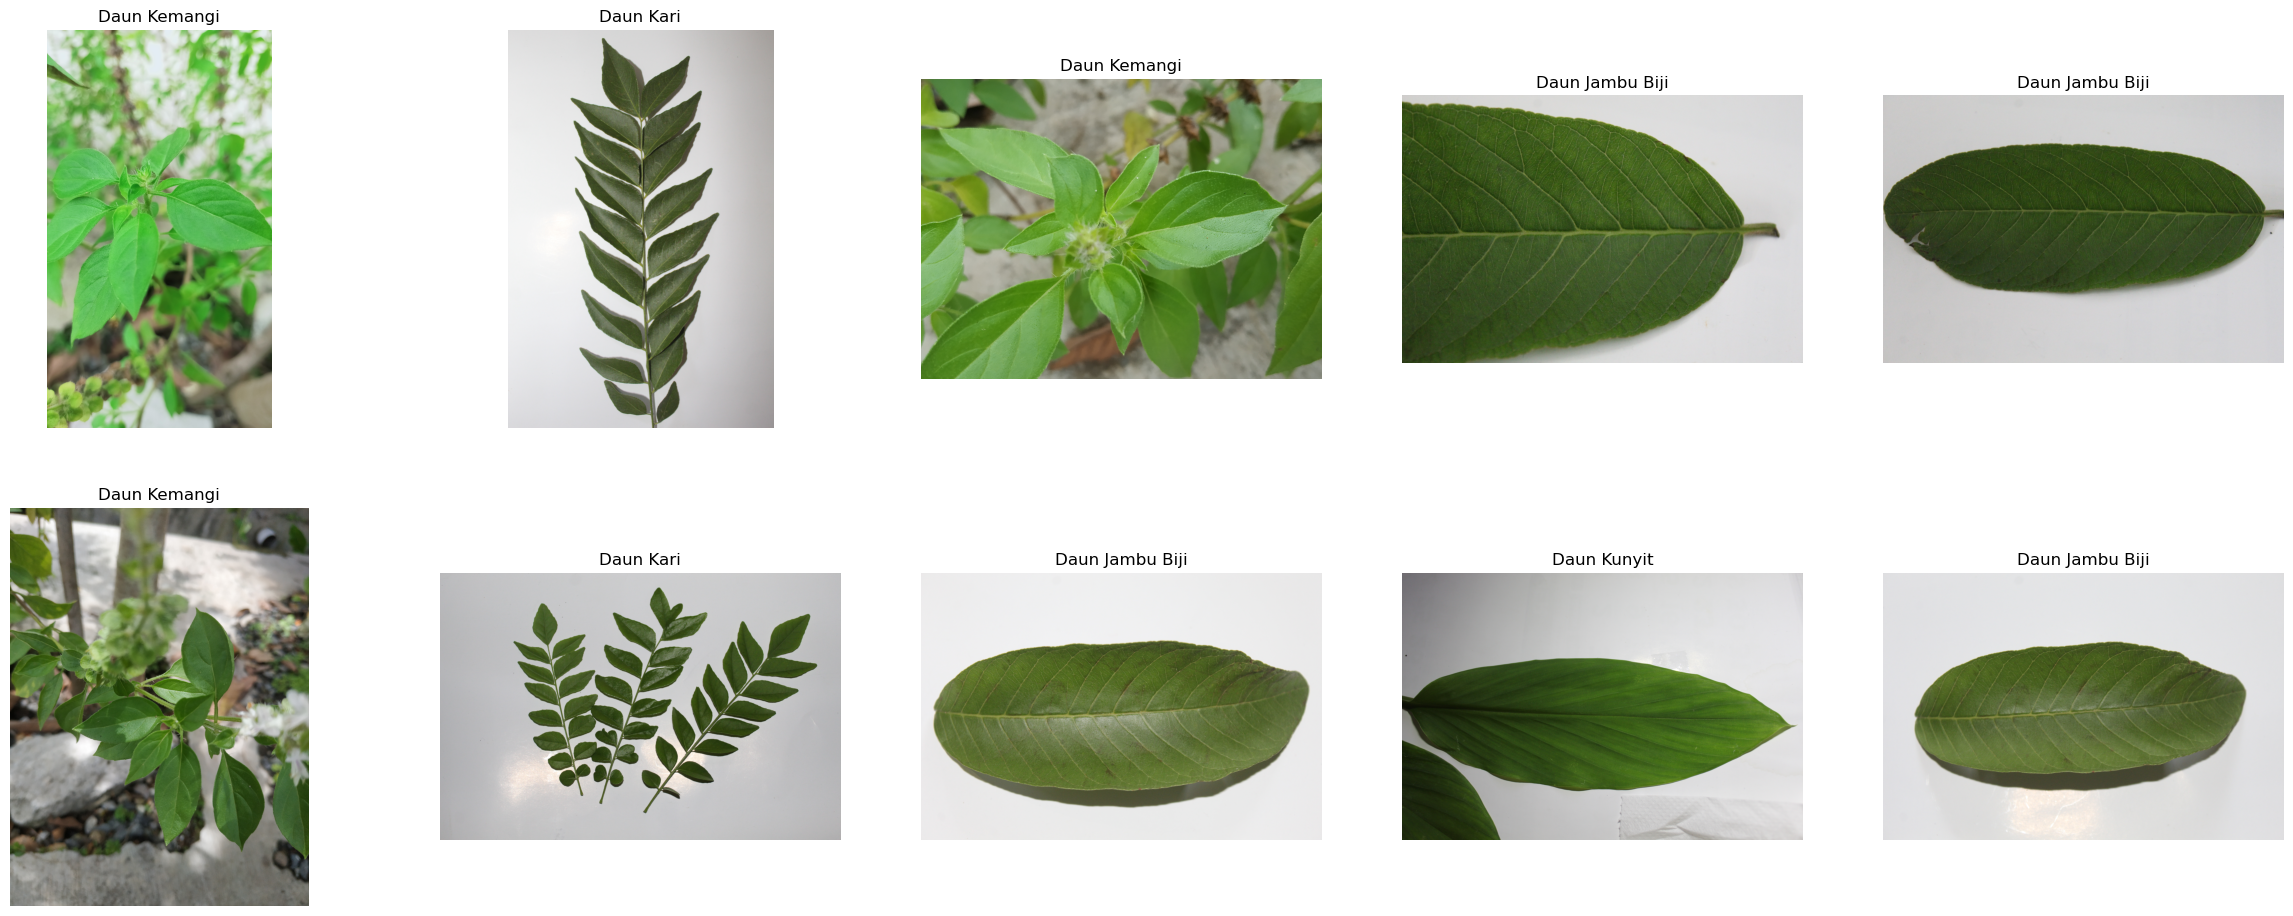

In [8]:
classes = os.listdir("../Skripsi Tanaman herbal/DATASET TANAMAN HERBAL/Data Training")

plt.figure(figsize=(30 , 30))
for x in range(10):
    i = random.randint(0,3)                    # getting the class
    images = os.listdir('../Skripsi Tanaman herbal/DATASET TANAMAN HERBAL/Data Training'+'/'+classes[i])
    j = random.randint(0,79)                  # getting the image
    image = cv2.imread('../Skripsi Tanaman herbal/DATASET TANAMAN HERBAL/Data Training'+'/'+classes[i]+'/'+images[j])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(5, 5, x + 1)
    plt.imshow(image)
    plt.title(classes[i])
    plt.axis("off")

plt.show()

# Dataset & DataLoader

In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [10]:
bs = 50
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((crop_size, crop_size)),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('../Skripsi Tanaman herbal/DATASET TANAMAN HERBAL/Data Training', transform=train_transform)
trainloader= DataLoader(train_set, batch_size=bs, shuffle=True)

test_set = datasets.ImageFolder("../Skripsi Tanaman herbal/DATASET TANAMAN HERBAL/Data Testing", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs)

In [11]:
len(train_set.targets) # untuk mengetahui jumlah dataset train

800

In [12]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([50, 3, 224, 224])

In [13]:
label2cat = train_set.classes
label2cat

['Daun Jambu Biji',
 'Daun Kari',
 'Daun Kemangi',
 'Daun Kunyit',
 'Daun Mint',
 'Daun Pepaya',
 'Daun Sirih',
 'Daun Sirsak',
 'Lidah Buaya',
 'Teh Hijau']

# Arsitektur & Config

In [12]:
from torchvision.models import resnet50

In [13]:
resnet = resnet50(pretrained=True)
resnet

E:\anaconda3\envs\jcopdl\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
E:\anaconda3\envs\jcopdl\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
from torchvision.models import resnet50
from jcopdl.layers import linear_block

class CustomResnet50(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.model = resnet50(pretrained=True)
        self.model.fc = linear_block(2048, output_size, activation="lsoftmax")
            
    def forward(self, x):
        return self.model(x)
    
config = set_config({
    "output_size": len(train_set.classes),
    "batch_size": bs,
    "crop_size": crop_size
})

# Training

In [15]:
model = CustomResnet50(config.output_size).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
callback = Callback(model, config, early_stop_patience=5, outdir="model_eksperimen_10") #catatan tadi ini eksperimen 9 lupa diganti

E:\anaconda3\envs\jcopdl\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
E:\anaconda3\envs\jcopdl\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:01<?, ?it/s]


Epoch     1
Train_cost  = 0.7857 | Test_cost  = 0.3675 | Train_score = 0.8512 | Test_score = 0.8800 |


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.0351 | Test_cost  = 0.1949 | Train_score = 0.9962 | Test_score = 0.9450 |


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.0125 | Test_cost  = 0.1696 | Train_score = 0.9988 | Test_score = 0.9650 |


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.0215 | Test_cost  = 0.1422 | Train_score = 0.9975 | Test_score = 0.9450 |
==> EarlyStop patience =  1 | Best test_score: 0.9650


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.0228 | Test_cost  = 0.1615 | Train_score = 0.9950 | Test_score = 0.9550 |
==> EarlyStop patience =  2 | Best test_score: 0.9650


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.0202 | Test_cost  = 0.1783 | Train_score = 0.9925 | Test_score = 0.9350 |
==> EarlyStop patience =  3 | Best test_score: 0.9650


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.0182 | Test_cost  = 0.2018 | Train_score = 0.9962 | Test_score = 0.9300 |
==> EarlyStop patience =  4 | Best test_score: 0.9650


Train:   0%|          | 0/16 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.0108 | Test_cost  = 0.1828 | Train_score = 0.9975 | Test_score = 0.9400 |
==> EarlyStop patience =  5 | Best test_score: 0.9650
==> Execute Early Stopping at epoch: 8 | Best test_score: 0.9650
==> Best model is saved at model_eksperimen_9


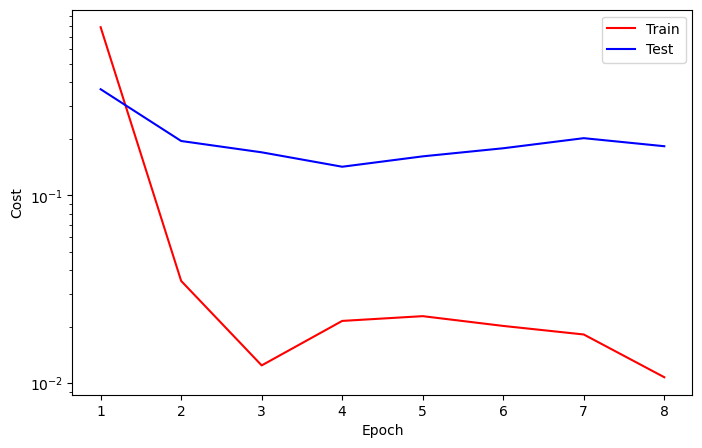

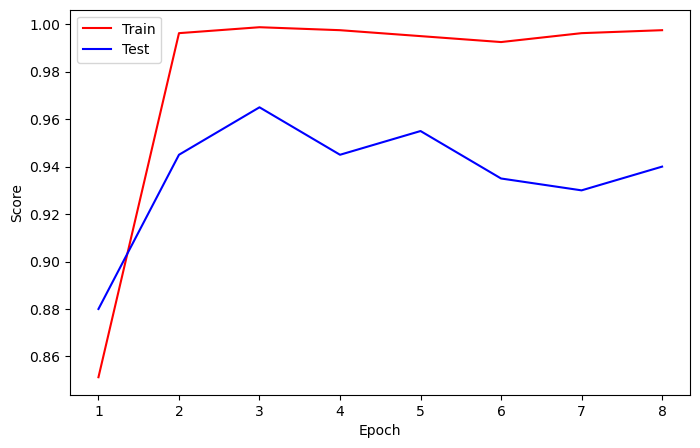

In [17]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Evaluation

In [18]:
test_set = datasets.ImageFolder("../Skripsi Tanaman herbal/DATASET TANAMAN HERBAL/Data Testing", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs)

with torch.no_grad():
    test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    print(f"Test accuracy: {test_score}")

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Test accuracy: 0.965


# Confusion matrix

In [19]:
y_true = []
y_pred = []
 
for data in tqdm(testloader):
  images,labels=data[0].to(device),data[1]  
  y_true.extend(labels.numpy())
 
  outputs=model(images)
 
  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

  0%|          | 0/4 [00:00<?, ?it/s]

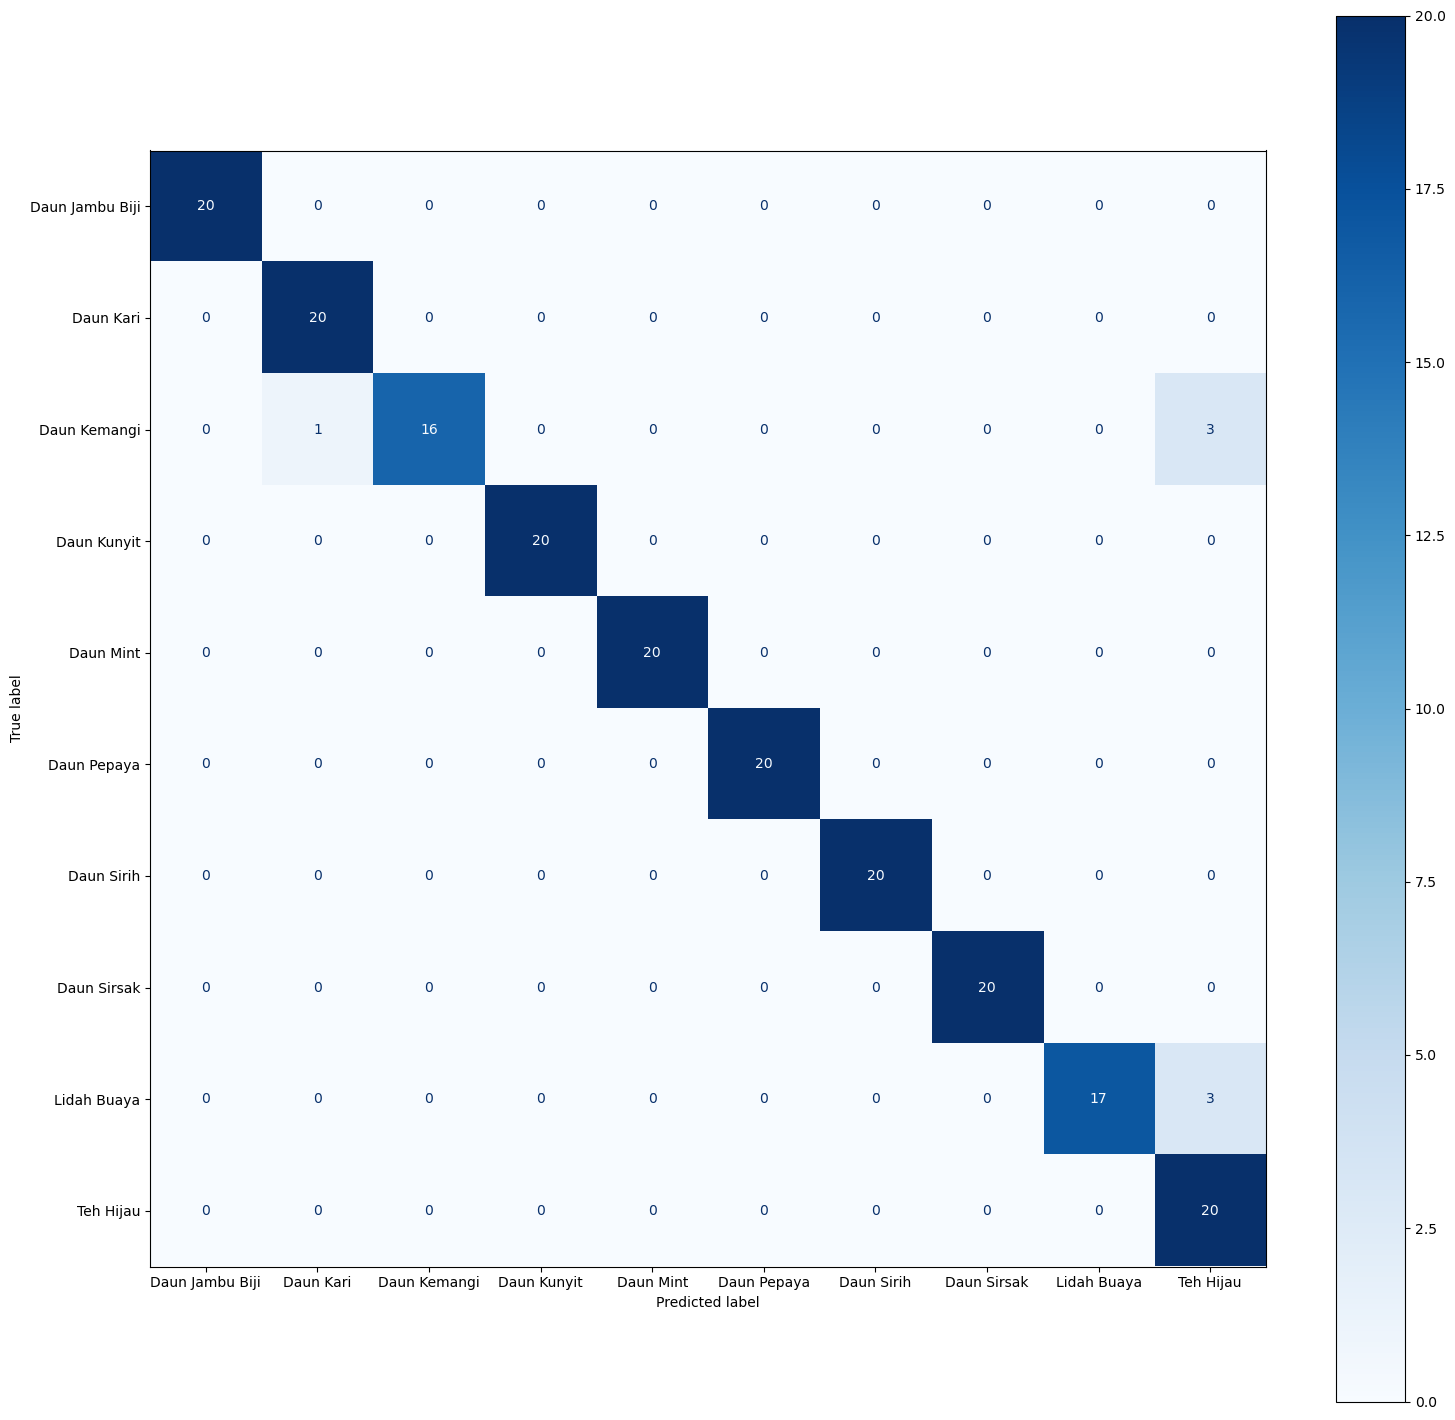

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ('Daun Jambu Biji', 'Daun Kari', 'Daun Kemangi', 'Daun Kunyit', 'Daun Mint', 'Daun Pepaya', 'Daun Sirih',
               'Daun Sirsak', 'Lidah Buaya', 'Teh Hijau')

# Create pandas dataframe
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=class_names)
fig, ax = plt.subplots(figsize=(18,18))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))

                 precision    recall  f1-score   support

Daun Jambu Biji       1.00      1.00      1.00        20
      Daun Kari       0.95      1.00      0.98        20
   Daun Kemangi       1.00      0.80      0.89        20
    Daun Kunyit       1.00      1.00      1.00        20
      Daun Mint       1.00      1.00      1.00        20
    Daun Pepaya       1.00      1.00      1.00        20
     Daun Sirih       1.00      1.00      1.00        20
    Daun Sirsak       1.00      1.00      1.00        20
    Lidah Buaya       1.00      0.85      0.92        20
      Teh Hijau       0.77      1.00      0.87        20

       accuracy                           0.96       200
      macro avg       0.97      0.97      0.97       200
   weighted avg       0.97      0.96      0.97       200

